In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [3]:
from typing import Tuple

import pandas as pd

from plotting import plot_ts
from load_dataset import Dataset
from model import TimeSeriesPredictor

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


### Какие ряды будем тестировать?

* длинный ряд с сезонностью  
* короткий ряд с сезонностью  
* короткий ряд с сезонностью и трендом  
* случайное блуждание  
* средне зашумленный ряд
* "шумный" ряд  

In [97]:
ds = Dataset('../data/dataset/')

In [98]:
long = ds['daily-min-temperatures.csv']

In [105]:
plot_ts(long)

Loading BokehJS ...

In [100]:
short_season = ds['hour_3019.csv'][300:]

In [110]:
plot_ts(short_season);

Loading BokehJS ...

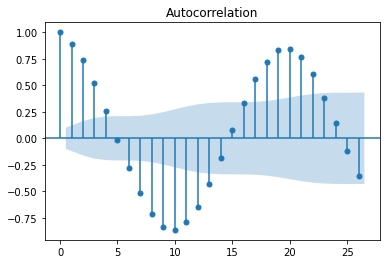

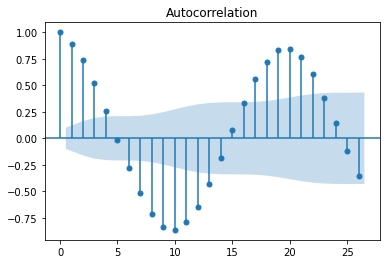

In [111]:
plot_acf(short_season)

<AxesSubplot:xlabel='2019-05-30T10:00:00'>

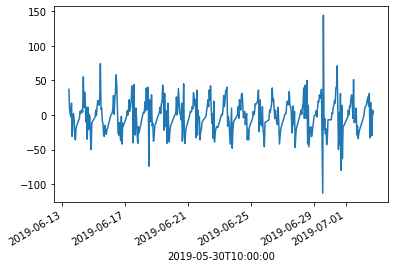

In [108]:
short_season.diff().plot()

In [102]:
short_season_trend = ds['international-airline-passengers.csv']

In [14]:
plot_ts(short_season_trend)

Loading BokehJS ...

In [117]:
plot_ts(np.log(short_season_trend) )

Loading BokehJS ...

In [121]:
short_season_trend_log = np.log(short_season_trend)

In [125]:
k, b = np.polyfit(range(len(short_season_trend_log)), short_season_trend_log.values, 1)


In [126]:
trend = pd.Series(k * np.array(range(len(short_season_trend_log))) + b, index=short_season_trend_log.index)

In [128]:
short_season_trend_log_detr = short_season_trend_log - trend

In [127]:
plot_ts(short_season_trend_log - trend )

Loading BokehJS ...

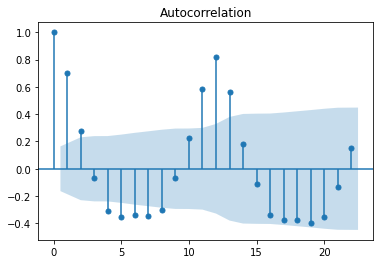

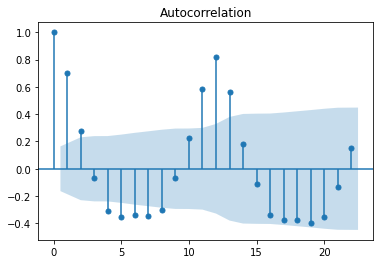

In [129]:
plot_acf(short_season_trend_log_detr)

<AxesSubplot:xlabel='1949-01'>

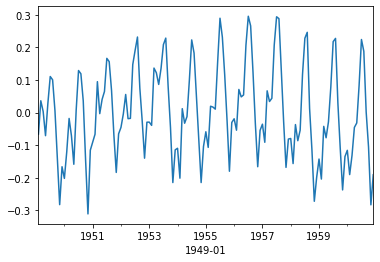

In [131]:
short_season_trend_log_detr.plot()

In [15]:
random_walk = ds['dow_jones_0.csv']

In [16]:
plot_ts(random_walk)

Loading BokehJS ...

In [17]:
medium_noize = ds['hour_3426.csv'][300:]

In [18]:
plot_ts(medium_noize)

Loading BokehJS ...

In [19]:
full_noize = ds['day_1574.csv']

In [20]:
plot_ts(full_noize)

Loading BokehJS ...

### Какие модели будем тестировать?

* скользящее среднее
* экспоненциальное сглаживание
* autoArima
* линейная регрессия
* линейная регрессия с L1 регуляризацией (Ridge)
* RandomForeset
* градиентный бустинг


In [61]:
from estimators import RollingEstimator, ExponentialSmoothingEstimator
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### По каким метрикам будем сравнивать?

* mse
* mae
* R2
* mape - если не будет ломаться на нулях
* mase

In [62]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

from metrics import mean_absolute_percentage_error as mape
from metrics import mase

### По какой методике будем тестировать?

* 70% трейн, 30% тест
* Out-of-sample, чтобы посмотреть как модель предсказывает "вдолгую"
* In-Sample, чтобы посмотреть как модель предсказывает на одну точку вперед
* Для поиска гиперпараметров можно делать кроссвалидацию на тесте по метрике mse

### Задание 1. Напишите функцию, разбивающую на train и test

In [63]:
def train_test_split(ts: pd.Series, ratio: float = 0.7) -> Tuple[pd.Series]:
    split_idx = int(len(ts) * ratio)
    ts_train, ts_test = ts[:split_idx], ts[split_idx:]
    return ts_train, ts_test

### Зададим соответствие гранулярностей для наших рядов.

### Задание 2. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через TimeSeriesPredictor.

* принмает на вход исходный ряд, гранулярность, количество лагов, модель, а также **kwargs, в которые мы будем передавать параметры модели

* разбивает ряд на train/test

* создает инстанс TimeSeriesPredictor с нужными параметрами

* обучает предиктор на трейне

* делает out_of_sample и in_sample прогноз

* возвращает train, test, in_sample, out_of_sample

In [22]:
import isodate

def make_pipeline(ts: pd.Series, granularity: str, num_lags: int, model: callable, **kwargs) -> Tuple[pd.Series]:
    train, test = train_test_split(ts)
    
    predictor = TimeSeriesPredictor(
        granularity=granularity,
        num_lags=num_lags,
        model=model
    )
    predictor.set_params(**kwargs)
    predictor.fit(ts)
    
    in_sample = predictor.predict_batch(train, test)
    
    first_dttm, last_dttm = train.index[-1], test.index[-1]
    horizon = (last_dttm - first_dttm) / isodate.parse_duration(granularity)
    out_of_sample = predictor.predict_next(train, n_steps=horizon)
    out_of_sample = out_of_sample[test.index]
    
    return train, test, in_sample, out_of_sample

### Задание 3. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через auto_arima

* функция должна принимать исходный временной ряд, период сезонности, параметры дифференцирования d, D и boolean параметр seasonal, данные параметры будут являться для нас гиперпараметрами, все остальное за нас должна найти auto_arima

* разбивает на train, test

* обучает arima на train при помощи вызова функции auto_arima из библиотеки pmdarima с переданными параметрами и со следующими зафиксированными параметрами: `max_p=3, max_q=3, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True`

* в качестве out_of_sample прогноза просто вызовите метод predict

* в качестве in_sample прогноза обучите модель заново на всём ряде методом `fit`, вызовите метод predict_in_sample и в качестве прогноза возьмите `in_sample_predictions(-len(test):)`

* возвращает train, test, in_sample, out_of_sample (не забудьте сделать их pd.Series с нужным индексом!!)

In [140]:
def make_pipeline_arima(
    ts: pd.Series, granularity: str,  period: int, d: int = 1, D: int = 1, seasonal: bool = True) -> Tuple[pd.Series]:
    train, test = train_test_split(ts)
    arima_fit = auto_arima(
        train,
        max_p=3, max_q=3, m=period,
        seasonal=seasonal,
        d=d, D=D,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    
    first_dttm, last_dttm = train.index[-1], test.index[-1]
    horizon = (last_dttm - first_dttm) / isodate.parse_duration(granularity)
    
    pd_freq = pd.DateOffset(isodate.parse_duration(granularity).total_seconds())
    out_of_sample = pd.Series(
        data=arima_fit.predict(int(horizon)),
        index=pd.date_range(start=first_dttm, end=last_dttm, freq=pd_freq)
    )
    out_of_sample = out_of_sample[test.index]
    
    in_sample = pd.Series(arima_fit.predict_in_sample()[-len(test):], index=test.index)
    
    return train, test, in_sample, out_of_sample

### Задание 4. Напишите функцию, имплементирующую поиск гиперпараметров по сетке. 

* функция должна принимать на вход ряд, гранулярность, модель, дефолтное количество лагов, сетку параметров (словарь)
* после написанного мной кода, функция должна с текущими параметрами запустить пайплайн (функция make_pipeline), получив таким образом прогнозы in_sample и out_of_sample
* посчитать mse для in_sample и out_of_sample прогноза, запомнить их в соответствующие словари
* вернуть лучшие параметры для in_sample и out_of_sample прогнозов

Замечания
* не забудьте, что в сетку параметров можно передавать также num_lags
* если в ряде ts_test есть пропуски, индекс прогноза out_of_sample будет не совпадать c индексом реальных данных, в таком случае, замените индекс out_of_sample прогноза индексом ts_test

In [58]:
import isodate

def make_pipeline(ts: pd.Series, granularity: str, num_lags: int, model: callable, **kwargs) -> Tuple[pd.Series]:
    train, test = train_test_split(ts)
    
    predictor = TimeSeriesPredictor(
        granularity=granularity,
        num_lags=num_lags,
        model=model
    )
    predictor.set_params(**kwargs)
    predictor.fit(ts)
    
    in_sample = predictor.predict_batch(train, test)
    
    first_dttm, last_dttm = train.index[-1], test.index[-1]
    horizon = (last_dttm - first_dttm) / isodate.parse_duration(granularity)
    out_of_sample = predictor.predict_next(train, n_steps=horizon)
    out_of_sample = out_of_sample[test.index]
    
    return train, test, in_sample, out_of_sample

In [59]:
from itertools import product

def hyperparameters_search(ts, granularity, model, num_lags, param_grid, verbose=False):    
    statistics_in_sample, statistics_out_of_sample = [], []

    for param_tuple in product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), param_tuple))
        
        # если в сетке есть num_lags, берем его, если нет, берем дефолтный num_lags из сигнатуры функции
        num_lags = params.pop('num_lags', None) or num_lags
        
        train, test, in_sample, out_of_sample = make_pipeline(ts, granularity, num_lags, model, **params )
        
        error_in_sample = mse(test, in_sample)
        error_out_of_sample = mse(test, out_of_sample)
        
        params['num_lags'] = num_lags
        
        statistics_in_sample.append((params, error_in_sample))
        statistics_out_of_sample.append((params, error_out_of_sample))
        
    
    best_in_sample = sorted(statistics_in_sample, key=lambda tup: tup[1])[0][1]
    best_out_of_sample = sorted(statistics_out_of_sample, key=lambda tup: tup[1])[0][1]
    best_out_of_sample_params = sorted(statistics_out_of_sample, key=lambda tup: tup[1])[0][0]
    
    return best_in_sample, best_out_of_sample,best_out_of_sample_params
    
        
        
        
        

### Задание 5. "Прогоните" все алгоритмы на всех рядах и получите сводную таблицу результатов по всем метрикам, постройте также графики прогнозов. 

In [6]:
from estimators import RollingEstimator, ExponentialSmoothingEstimator
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [40]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

from metrics import mean_absolute_percentage_error as mape
from metrics import mase

In [55]:
granularity_mapping = {
    'long': 'P1D',
    'short_season': 'PT1H',
    'short_season_trend': 'P1M',
    'random_walk': 'P1D',
    'medium_noise': 'PT1H',
    'full_noise': 'P1D'
}

In [21]:
dataset_mapping = {
    "long": long,
    "short_season": short_season,
    "short_season_trend": short_season_trend,
    "random_walk": random_walk, 
    "medium_noise": medium_noize,
    "full_noise": full_noize
}

In [132]:
dataset_arima_mapping = {
        "long": None,
    "short_season": (20, 1, 1, True),
    "short_season_trend": (12, 1, 1, True),
    "random_walk": (0, 1, 1, False), 
    "medium_noise": (0, 1, 1, False),
    "full_noise": (0, 1, 1, False)
}

In [24]:
param_grid_default = {
    'num_lags': [12, 24, 36]
}

In [22]:
param_grid_ridge = {
    'num_lags': [12, 24, 36],
    'alpha': [0, 1, 3, 10],
    'normalize': [True, False]
}

In [35]:
param_grid_rf = {
    'num_lags': [12, 24, 36],
    'max_depth': list(range(3, 10)),
    'n_estimators': [10, 50,  100]
}

In [37]:
param_grid_gb = {
    'num_lags': [12, 24, 36],
    'max_depth': [3, 4, 5, 6],
    'subsample': np.arange(.5, 1.01, .1),
    'n_estimators': [10, 50,  100]
}

In [27]:
param_grid_exp_smoothing = {
    'num_lags': [12, 24, 36],
    'alpha_coef': np.arange(.1, .9, .1)
}

In [38]:
models_mapping = {
    "rolling": (RollingEstimator, param_grid_default),
    "exponential_smoothing": (ExponentialSmoothingEstimator, param_grid_exp_smoothing),
    "auto_arima": (auto_arima, None),
    "linear_reg": (LinearRegression, param_grid_default),
    "ridge": (Ridge, param_grid_ridge),
    "rf": (RandomForestRegressor, param_grid_rf),
    "gb": (GradientBoostingRegressor, param_grid_gb)
}

In [42]:
metrics_mapping = {
    'mse': mse,
    'mae': mae,
    'r2': r2_score,
    "mase": mase
}

In [77]:
default_num_lags = 12

In [39]:
final_results = []

In [133]:
dataset_name, dataset = list(dataset_mapping.items())[1]

In [134]:
model_name, (model, params_grid) = list(models_mapping.items())[2]

In [141]:
dataset_gran = granularity_mapping[dataset_name]

res_model = {}

res_model['dataset'] = dataset_name

res_model['model'] = model_name

if model_name == 'auto_arima':
#     if dataset_name == 'long':
#         continue
    period, d, D, seasonal = dataset_arima_mapping[dataset_name]
    _, test, in_sample_best, out_of_sample_best = \
        make_pipeline_arima(dataset, dataset_gran, period=period, d=d, D=D, seasonal=seasonal)
else:

    best_in_sample, best_out_of_sample, best_out_of_sample_params = \
        hyperparameters_search(dataset, dataset_gran, model, default_num_lags, params_grid )

    num_lags = best_out_of_sample_params.pop('num_lags', None)

    _, test, in_sample_best, out_of_sample_best = \
        make_pipeline(dataset, dataset_gran, num_lags, model, **best_out_of_sample_params)

for metr_name, metric in metrics_mapping.items():
    res_model[metr_name+'_ins'] = metric(test, in_sample_best)
    res_model[metr_name+'_oos'] = metric(test, out_of_sample_best)    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[20]             : AIC=2137.047, Time=1.96 sec
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=2231.580, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=2139.680, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=2133.283, Time=0.63 sec
 ARIMA(0,1,1)(0,1,0)[20]             : AIC=2175.376, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[20]             : AIC=2135.139, Time=0.92 sec
 ARIMA(0,1,1)(0,1,2)[20]             : AIC=2135.188, Time=3.02 sec
 ARIMA(0,1,1)(1,1,0)[20]             : AIC=2138.821, Time=0.36 sec
 ARIMA(0,1,1)(1,1,2)[20]             : AIC=2135.956, Time=5.43 sec
 ARIMA(0,1,0)(0,1,1)[20]             : AIC=2146.677, Time=0.52 sec
 ARIMA(1,1,1)(0,1,1)[20]             : AIC=2134.638, Time=1.41 sec
 ARIMA(0,1,2)(0,1,1)[20]             : AIC=2134.334, Time=1.25 sec
 ARIMA(1,1,0)(0,1,1)[20]             : AIC=2133.111, Time=0.88 sec
 ARIMA(1,1,0)(0,1,0)[20]             : AIC=2183.880, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1

ValueError: Length of values (143) does not match length of index (1)

In [142]:
%debug

> /home/adima/src/1_projects/ts_autumn/ts/lib/python3.7/site-packages/pandas/core/common.py(532)require_length_match()
    530     if len(data) != len(index):
    531         raise ValueError(
--> 532             "Length of values "
    533             f"({len(data)}) "
    534             "does not match length of index "



ipdb>  u


> /home/adima/src/1_projects/ts_autumn/ts/lib/python3.7/site-packages/pandas/core/series.py(430)__init__()
    428                 index = ibase.default_index(len(data))
    429             elif is_list_like(data):
--> 430                 com.require_length_match(data, index)
    431 
    432             # create/copy the manager



ipdb>  u


> /tmp/ipykernel_4846/1921170143.py(21)make_pipeline_arima()
     19     out_of_sample = pd.Series(
     20         data=arima_fit.predict(int(horizon)),
---> 21         index=pd.date_range(start=first_dttm, end=last_dttm, freq=pd_freq)
     22     )
     23     out_of_sample = out_of_sample[test.index]



ipdb>  int(horizon)


143


ipdb>  first_dttm


Timestamp('2019-06-26 19:00:00')


ipdb>  last_dttm


Timestamp('2019-07-02 18:00:00')


ipdb>  pd_freq


<3600 * DateOffsets>


ipdb>  pd.date_range(start=first_dttm, end=last_dttm, freq=pd_freq)


DatetimeIndex(['2019-06-26 19:00:00'], dtype='datetime64[ns]', freq='<3600 * DateOffsets>')


ipdb>  exit


In [93]:
final_results.append(res_model)

In [139]:
%debug

> /home/adima/src/1_projects/ts_autumn/ts/lib/python3.7/site-packages/pmdarima/arima/arima.py(662)predict()
    660         check_is_fitted(self, 'arima_res_')
    661         if not isinstance(n_periods, int):
--> 662             raise TypeError("n_periods must be an int")
    663 
    664         # Temporary shim until we remove `exogenous` support completely



ipdb>  u


> /tmp/ipykernel_4846/3819214418.py(20)make_pipeline_arima()
     18     pd_freq = pd.DateOffset(isodate.parse_duration(granularity).total_seconds())
     19     out_of_sample = pd.Series(
---> 20         data=arima_fit.predict(horizon),
     21         index=pd.date_range(start=first_dttm, end=last_dttm, freq=pd_freq)
     22     )



ipdb>  horizon


143.0


ipdb>  exit
